In [1]:
import numpy as np
import os
import h5py
import tables
from scipy.io import loadmat

from keras.preprocessing import image

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing import image

pascal3d_path = '/home/sprokudin/biternionnet/data/PASCAL3D+_release1.1'

def get_imagenet_data(pascal3d_path, class_name):

    
    def _load_image(img_path):

        img = image.load_img(img_path, target_size=(224, 224))
        x = np.asarray(img)

        return x 
    
    def _parse_annotation(mat_path):
    
        ann = loadmat(mat_path)

        cls_name = ann['record'][0][0][1][0][0][0]
        # bbox = ann['record'][0][0][1][0][0][1]
        viewpoint = ann['record'][0][0][1][0][0][3][0][0]

        azimuth = viewpoint[2]
        elevation = viewpoint[3]
        tilt = viewpoint[8]
        #distance =  viewpoint[4]

        #viewpoint = np.asarray([azimuth, elevation, distance])

        return azimuth, elevation
    
    #ann_path_pascal = os.path.join(pascal3d_path, 'Annotations/%s_pascal/'%class_name)
    ann_path_imagenet = os.path.join(pascal3d_path, 'Annotations/%s_imagenet/'%class_name)
    #imgs_path_pascal =os.path.join(pascal3d_path, 'Images/%s_pascal/'%class_name)
    imgs_path_imagenet = os.path.join(pascal3d_path, 'Images/%s_imagenet/'%class_name)   
    
    #pascal_annotations = os.listdir(ann_path_pascal)
    #pascal_images_fpath = [os.path.join(imgs_path_pascal, ann.split('.')[0]+'.jpg') for ann in pascal_annotations]
    #pascal_annotations_fpath = [os.path.join(ann_path_pascal, ann) for ann in pascal_annotations]

    imagenet_annotations = os.listdir(ann_path_imagenet)
    imagenet_images_fpath = [os.path.join(imgs_path_imagenet, ann.split('.')[0]+'.JPEG') for ann in imagenet_annotations]
    imagenet_annotations_fpath = [os.path.join(ann_path_imagenet, ann) for ann in imagenet_annotations]

    labels = np.zeros([len(imagenet_annotations), 3])
    images = np.zeros([len(imagenet_annotations), 224, 224, 3], dtype='uint8')

    for i in range(0, len(imagenet_annotations)):
        azimuth, elevation = _parse_annotation(imagenet_annotations_fpath[i])
        labels[i, 0] = azimuth
        labels[i, 1] = elevation
        images[i] = _load_image(imagenet_images_fpath[i])
        if i%50 == 0 :
            print("parsed %d samples.."% i)
    
    azimuth_deg =  labels[:, 0]
    elevation_deg =  labels[:, 1]
    tilt_deg =  labels[:, 2]

    data = {'images': images,
            'azimuth_deg': azimuth_deg.reshape([-1, 1]),
            'azimuth_bit': deg2bit(azimuth_deg),
            'elevation_deg': elevation_deg.reshape([-1, 1]),
            'elevation_bit': deg2bit(elevation_deg),
            'tilt_deg': tilt_deg.reshape([-1, 1]),
            'tilt_bit': deg2bit(tilt_deg)}
    
    return data

In [3]:
from utils.angles import bit2deg, deg2bit, rad2bit
imagenet_train_data = get_imagenet_data(pascal3d_path, 'aeroplane')

parsed 0 samples..
parsed 50 samples..
parsed 100 samples..
parsed 150 samples..
parsed 200 samples..
parsed 250 samples..
parsed 300 samples..
parsed 350 samples..
parsed 400 samples..
parsed 450 samples..
parsed 500 samples..
parsed 550 samples..
parsed 600 samples..
parsed 650 samples..
parsed 700 samples..
parsed 750 samples..
parsed 800 samples..
parsed 850 samples..
parsed 900 samples..
parsed 950 samples..
parsed 1000 samples..
parsed 1050 samples..
parsed 1100 samples..
parsed 1150 samples..
parsed 1200 samples..
parsed 1250 samples..
parsed 1300 samples..
parsed 1350 samples..
parsed 1400 samples..
parsed 1450 samples..
parsed 1500 samples..
parsed 1550 samples..
parsed 1600 samples..
parsed 1650 samples..
parsed 1700 samples..
parsed 1750 samples..
parsed 1800 samples..
parsed 1850 samples..
parsed 1900 samples..
parsed 1950 samples..


In [4]:
from utils.angles import bit2deg, deg2bit

def stitch_data_dicts(real_dict, syn_dict):

    stitched = {}
    for key in real_dict.keys():    
        stitched[key] = np.vstack([real_dict[key], syn_dict[key]])

    return stitched

def train_val_split(data, val_split=0.1):

    n_samples = len(data['images'])

    shuffled_samples = np.random.choice(n_samples, n_samples, replace=False)
    n_train = int((1-val_split)*n_samples)
    train_samples = shuffled_samples[0:n_train]
    val_samples = shuffled_samples[n_train:]

    train_data = {} 
    val_data = {}

    for key in data.keys():
        train_data[key] = data[key][train_samples]
        val_data[key] = data[key][val_samples]

    return train_data, val_data

def get_data(dbpath, class_name, 
             use_real=True,
             use_synthetic=True, 
             test_bboxes='gt'):
    
    pascal_db = h5py.File(dbpath, 'r')

    def _get_data_part(h5path):
        
        images = np.asarray(pascal_db[os.path.join(h5path, 'images')])
        labels = np.asarray(pascal_db[os.path.join(h5path, 'labels')])
        azimuth_deg =  labels[:, 1]
        elevation_deg =  labels[:, 2]
        tilt_deg =  labels[:, 3]

        data = {'images': images,
                'azimuth_deg': azimuth_deg.reshape([-1, 1]),
                'azimuth_bit': deg2bit(azimuth_deg),
                'elevation_deg': elevation_deg.reshape([-1, 1]),
                'elevation_bit': deg2bit(elevation_deg),
                'tilt_deg': tilt_deg.reshape([-1, 1]),
                'tilt_bit': deg2bit(tilt_deg)}
        
        return data
    
    if use_synthetic and use_real:
        train_data_real = _get_data_part(os.path.join('train_real', class_name))
        train_data_syn = _get_data_part(os.path.join('train_synthetic', class_name))
        train_data = stitch_data_dicts(train_data_real, train_data_syn)
    elif use_synthetic:
        train_data = _get_data_part(os.path.join('train_synthetic', class_name))
    elif use_real:
        train_data = _get_data_part(os.path.join('train_real', class_name))
    
    if test_bboxes == 'gt':
        test_data_real = _get_data_part(os.path.join('test_real_gt_boxes', class_name))
    else:
        test_data_real = _get_data_part(os.path.join('test_real_frcnn_boxes', class_name))
    
    # test_data_syn = _get_data_part(os.path.join('test_syn_boxes', class_name))
    
    data = {'train': train_data,
            'test': test_data_real}
    
    pascal_db.close()
    
    return train_data, test_data_real

In [19]:
dbpath = '../data/pascal3d_real_synthetic100k.h5'

pascal_train_data, test_data = get_data(dbpath, 'aeroplane', use_synthetic=False)

train_val_data = stitch_data_dicts(pascal_train_data, imagenet_train_data)

train_real_data, val_data = train_val_split(train_val_data, val_split=0.2)

#train_syn_data, _ = get_data(dbpath, 'aeroplane', use_real=False)
#train_data = stitch_data_dicts(train_real_data, train_syn_data)
train_data = train_real_data

n_train_images, image_height, image_width, n_channels = train_data['images'].shape

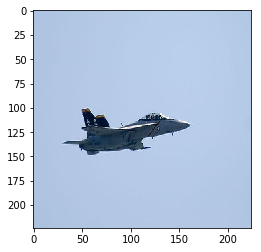

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(np.asarray(train_data['images'][81], dtype='uint8'))

In [7]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50

from models import vgg

from utils.losses import maad_from_deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras


def biternion_disco(image_height, image_width, n_channels,
                   debug=False,
                  name='biternion_cnn', loss_type='cosine',
                  backbone_cnn_type='inception_resnet',
                  add_noise=True,
                  n_samples=5,
                  z_size=8,
                  hlayer_size=512,
                  noise_std=1.0,
                  learning_rate=1.0e-3, fixed_kappa=1.0):
    
    if debug:
        X_input = Input(shape=[image_height, image_width, n_channels], name='input_image')

        x = Flatten(input_shape=[image_height, image_width, n_channels])(X_input)
    else:
        backbone_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                                          input_shape=[image_height, image_width, n_channels])
        x = backbone_model.output
        x = GlobalAveragePooling2D()(x)

    x = Dense(hlayer_size, activation='relu')(x)
    
    def _sample_z(x):
        #return K.ones(shape=K.shape(x[:, 0:z_size]))
        return K.random_normal(shape=K.shape(x[:, 0:z_size]), mean=0., stddev=noise_std)

    #z = Lambda(_sample_z)(x)
    decoder_seq = Sequential(name='decoder')
    if add_noise:
        decoder_seq.add(Dense(hlayer_size, activation='relu', input_shape=[hlayer_size+z_size]))
    else:
        decoder_seq.add(Dense(hlayer_size, activation='relu', input_shape=[hlayer_size]))
    
    decoder_seq.add(Dense(hlayer_size, activation='relu'))

    decoder_mean = Sequential()
    decoder_mean.add(decoder_seq)
    decoder_mean.add((Dense(2, activation='linear')))
    decoder_mean.add(Lambda(lambda x: K.l2_normalize(x, axis=1), name='theta_mean'))

    decoder_kappa = Sequential()
    decoder_kappa.add(decoder_seq)
    decoder_kappa.add((Dense(1,  activation='linear')))
    decoder_kappa.add(Lambda(lambda x: K.abs(x), name='theta_kappa'))

    z_lst = []
    x_z_lst = []
    x_z_decoded_lst = []
    
    if add_noise:
        for k in range(0, n_samples):
            z_lst.append(Lambda(_sample_z)(x))
            x_z_lst.append(concatenate([x, z_lst[k]]))
            #x_z_decoded_lst.append(decoder_kappa(x_z_lst[k]))
            x_z_decoded_lst.append(concatenate([decoder_mean(x_z_lst[k]), decoder_kappa(x_z_lst[k])]))

        x_z_decoded_all = concatenate(x_z_decoded_lst)
    else:
        x_z_decoded_all = concatenate([decoder_mean(x), decoder_kappa(x)])
    
    # model = Model(backbone_model.input, x_z_decoded_all )
    if debug:
        model = Model(X_input, x_z_decoded_all )
    else:
        model = Model(backbone_model.input, x_z_decoded_all)
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]

        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    def _loss(y_target, y_pred):
        
        theta_mean, theta_kappa = _unpack_preds(y_pred)
        theta_target = _unpack_target(y_target)
        
        loss = -von_mises_log_likelihood_tf(theta_target, theta_mean, theta_kappa)
             
        return loss
    
    def _mc_loss(y_target, y_pred):
        
        sample_likelihoods = []
        
        for sid in range(0, n_samples):
            
            sample_likelihoods.append(von_mises_log_likelihood_tf(y_target, 
                                                                   y_pred[:, sid*3:sid*3+2], 
                                                                   y_pred[:, sid*3+2:sid*3+3]))
            
        
        mc_likelihood = -K.mean(concatenate(sample_likelihoods), axis=1)
                      
        return mc_likelihood
    
    opt = Adam(lr=learning_rate)
    
    if add_noise:
        model.compile(optimizer=opt, loss=_mc_loss)
    else:
        model.compile(optimizer=opt, loss=_loss)
        
    return model

In [10]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(n_epochs=15, batch_size=32, learning_rate=1.0e-4, iteration=0):
    
    ckpt_path = '../logs/azimuth_disco_single_iter%d.ckpt'%iteration
    angle = 'azimuth'
    angle_key = angle+'_bit'
    
    K.clear_session()
    n_samples= 1
    bidisco = biternion_disco(image_height, image_width, n_channels,
                              debug=False,
                              n_samples=n_samples, 
                              hlayer_size=512,
                              add_noise=False,
                              z_size=2, noise_std=1.0e0,
                              learning_rate=learning_rate)

    early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

    model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    time_callback = TimeHistory()

    bidisco.fit(train_data['images'], train_data[angle_key],
              validation_data=[val_data['images'], val_data[angle_key]],
              epochs=n_epochs,
              batch_size=batch_size,
              callbacks=[early_stop_cb, model_ckpt, time_callback])

    bidisco.load_weights(ckpt_path)
    print("FINAL LOG-LIKELIHOOD: %f" % bidisco.evaluate(test_data['images'], test_data['azimuth_bit']))

In [35]:
for i in range(0, 10):
    train_model(n_epochs=20, batch_size=32, iteration=i, learning_rate=1.0e-3)

Train on 2247 samples, validate on 562 samples
Epoch 1/20
2247/2247 [==============================] - 129s 58ms/step - loss: 1.6252 - val_loss: 1.8037

Epoch 00001: val_loss improved from inf to 1.80371, saving model to ../logs/azimuth_disco_single_iter0.ckpt
Epoch 2/20
2247/2247 [==============================] - 114s 51ms/step - loss: 1.0538 - val_loss: 1.1328

Epoch 00002: val_loss improved from 1.80371 to 1.13283, saving model to ../logs/azimuth_disco_single_iter0.ckpt
Epoch 3/20
2247/2247 [==============================] - 114s 51ms/step - loss: 0.6559 - val_loss: 1.8349

Epoch 00003: val_loss did not improve
Epoch 4/20
2247/2247 [==============================] - 114s 51ms/step - loss: 0.4600 - val_loss: 0.9703

Epoch 00004: val_loss improved from 1.13283 to 0.97028, saving model to ../logs/azimuth_disco_single_iter0.ckpt
Epoch 5/20
2247/2247 [==============================] - 114s 51ms/step - loss: 0.1869 - val_loss: 0.8703

Epoch 00005: val_loss improved from 0.97028 to 0.8702

2247/2247 [==============================] - 111s 50ms/step - loss: -0.3422 - val_loss: 2.0986

Epoch 00010: val_loss did not improve
Epoch 11/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.1912 - val_loss: 1.6993

Epoch 00011: val_loss did not improve
Epoch 12/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.2732 - val_loss: 3.7697

Epoch 00012: val_loss did not improve
Epoch 13/20
2247/2247 [==============================] - 111s 50ms/step - loss: 0.0514 - val_loss: 1.9004

Epoch 00013: val_loss did not improve
Epoch 14/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.4324 - val_loss: 1.0632

Epoch 00014: val_loss did not improve
Epoch 15/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.6362 - val_loss: 1.5022

Epoch 00015: val_loss did not improve
Epoch 16/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.7055 - val_loss: 1.4510

Epoch 00016: val_loss did not

2247/2247 [==============================] - 111s 50ms/step - loss: -0.8704 - val_loss: 3.3511

Epoch 00020: val_loss did not improve
275/275 [==============================] - 4s 14ms/step
FINAL LOG-LIKELIHOOD: 1.527545
Train on 2247 samples, validate on 562 samples
Epoch 1/20
2247/2247 [==============================] - 123s 55ms/step - loss: 1.6694 - val_loss: 1.8935

Epoch 00001: val_loss improved from inf to 1.89347, saving model to ../logs/azimuth_disco_single_iter5.ckpt
Epoch 2/20
2247/2247 [==============================] - 111s 50ms/step - loss: 1.0015 - val_loss: 1.1794

Epoch 00002: val_loss improved from 1.89347 to 1.17943, saving model to ../logs/azimuth_disco_single_iter5.ckpt
Epoch 3/20
2247/2247 [==============================] - 111s 50ms/step - loss: 0.4873 - val_loss: 2.1607

Epoch 00003: val_loss did not improve
Epoch 4/20
2247/2247 [==============================] - 111s 50ms/step - loss: 0.2230 - val_loss: 0.9356

Epoch 00004: val_loss improved from 1.17943 to 0.9

2247/2247 [==============================] - 111s 50ms/step - loss: -0.1728 - val_loss: 1.6714

Epoch 00008: val_loss did not improve
Epoch 9/20
2247/2247 [==============================] - 112s 50ms/step - loss: -0.2714 - val_loss: 1.9693

Epoch 00009: val_loss did not improve
Epoch 10/20
2247/2247 [==============================] - 111s 50ms/step - loss: 0.1370 - val_loss: 1.9933

Epoch 00010: val_loss did not improve
Epoch 11/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.2951 - val_loss: 2.5880

Epoch 00011: val_loss did not improve
Epoch 12/20
2247/2247 [==============================] - 112s 50ms/step - loss: -0.5391 - val_loss: 2.7658

Epoch 00012: val_loss did not improve
Epoch 13/20
2247/2247 [==============================] - 112s 50ms/step - loss: -0.5325 - val_loss: 2.5959

Epoch 00013: val_loss did not improve
Epoch 14/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.1467 - val_loss: 14.7690

Epoch 00014: val_loss did not

2247/2247 [==============================] - 112s 50ms/step - loss: -0.2953 - val_loss: 2.1617

Epoch 00019: val_loss did not improve
Epoch 20/20
2247/2247 [==============================] - 111s 50ms/step - loss: -0.5475 - val_loss: 1.5419

Epoch 00020: val_loss did not improve
275/275 [==============================] - 4s 14ms/step
FINAL LOG-LIKELIHOOD: 1.623354


In [12]:
bidisco.load_weights(ckpt_path)
bidisco.evaluate(test_data['images'], test_data['azimuth_bit'])

275/275 [==============================] - 5s 18ms/step


0.9529263162612915

START!!!
275/275 [==============================] - 4s 15ms/step
MAAD (1 sample) : 26.554062
275/275 [==============================] - 4s 14ms/step
log-likelihood: 0.952926


/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


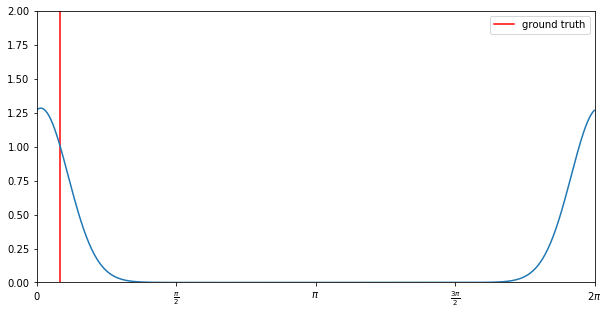

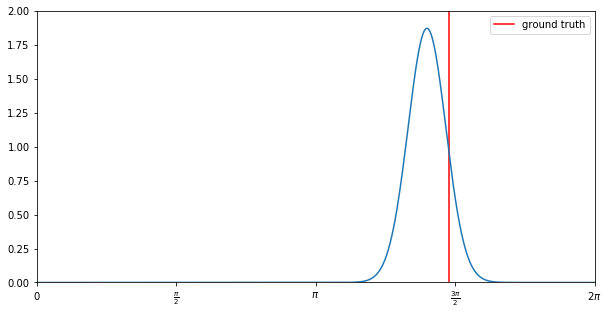

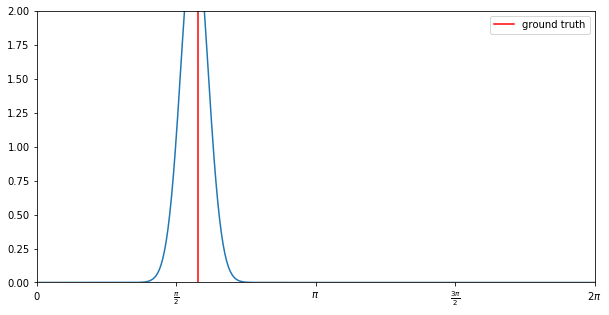

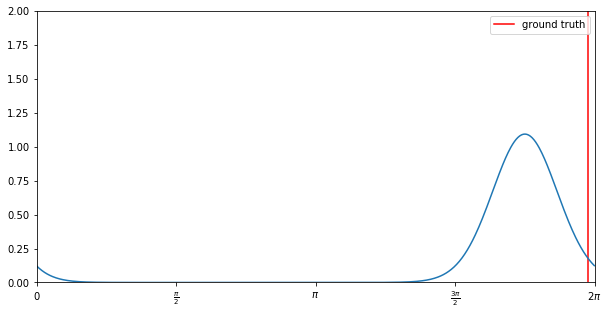

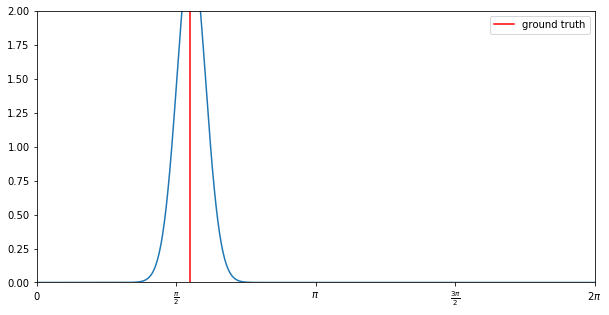

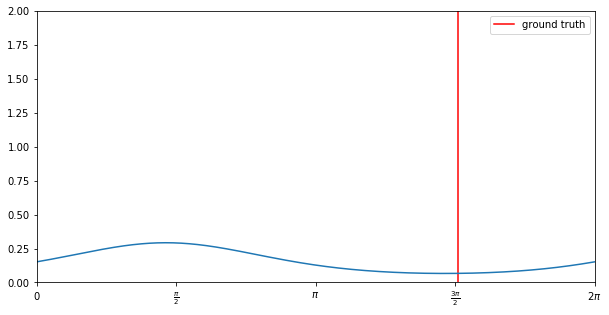

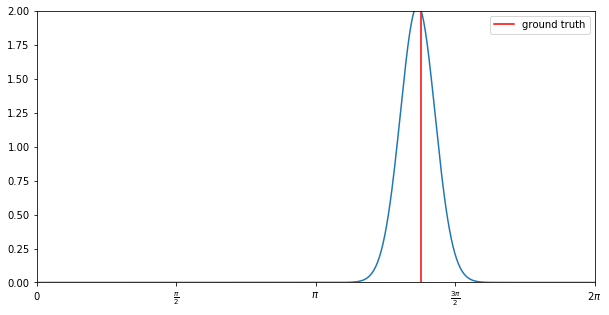

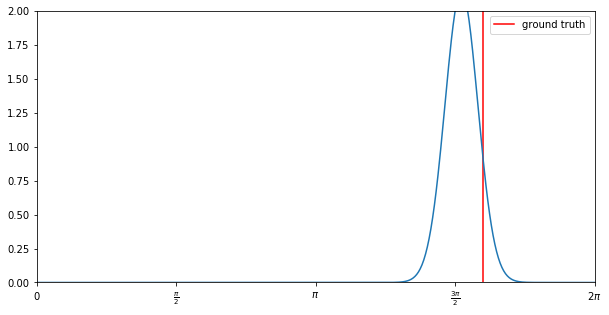

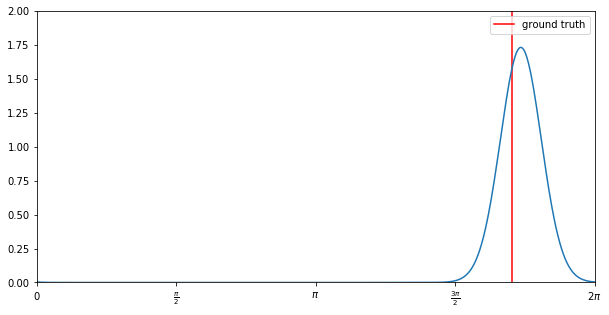

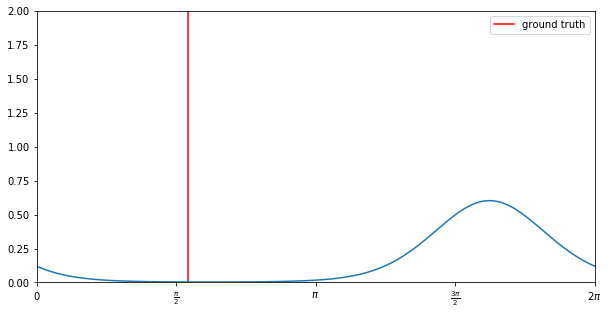

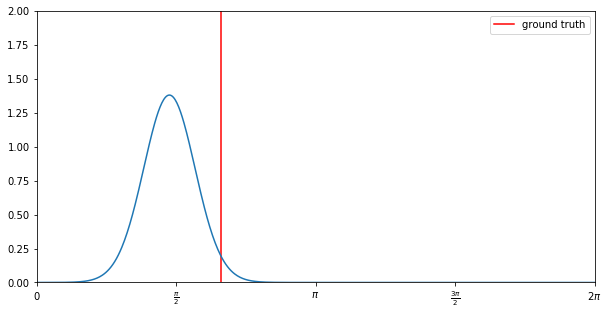

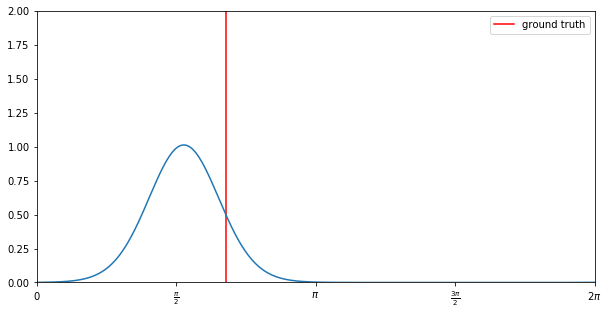

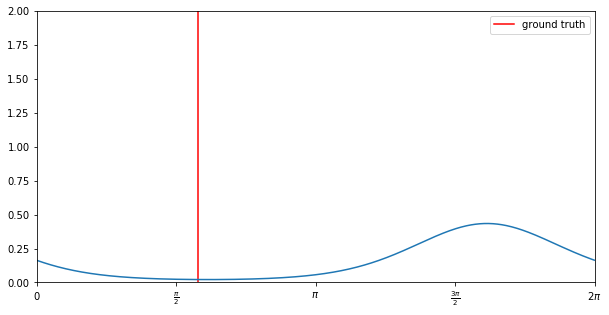

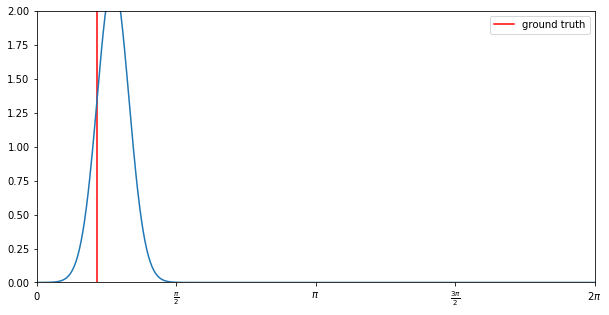

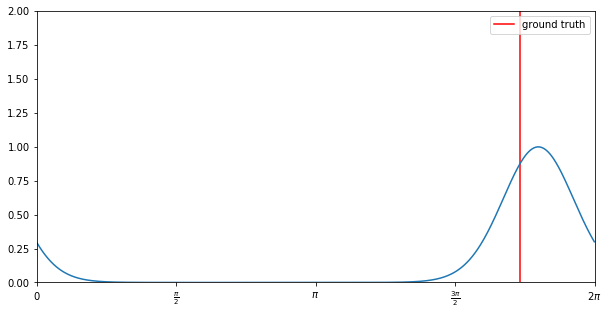

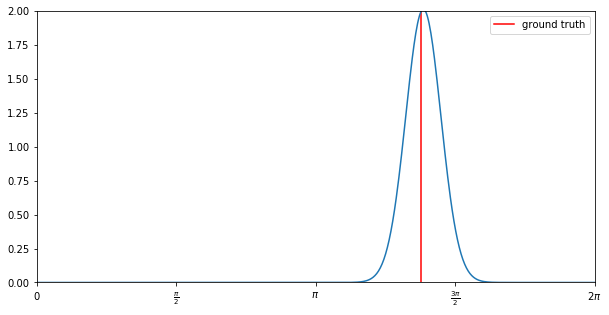

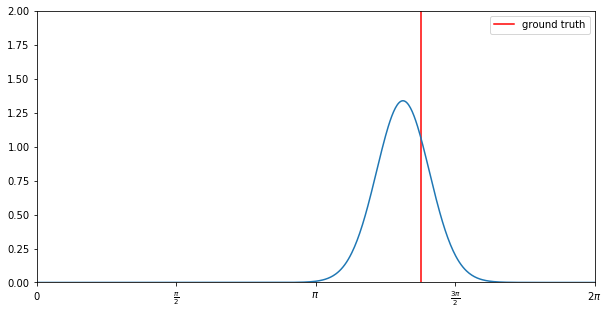

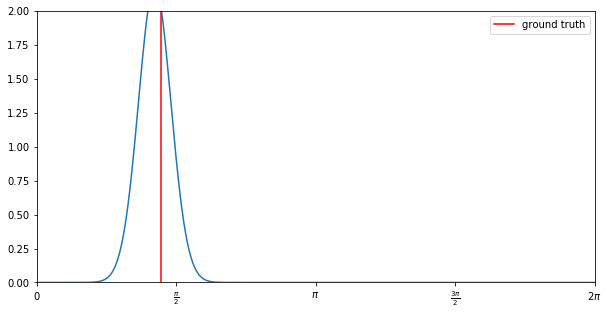

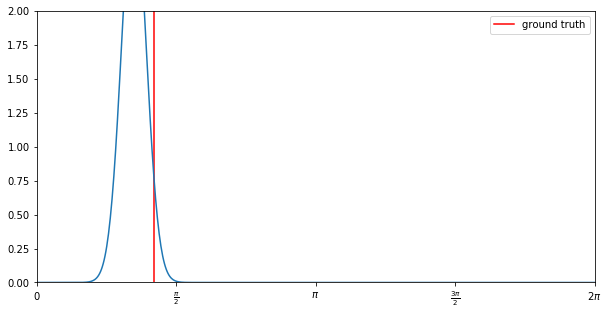

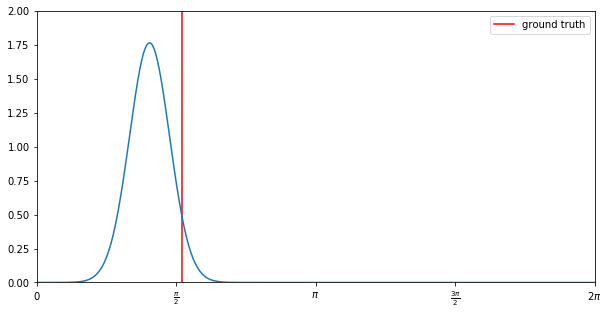

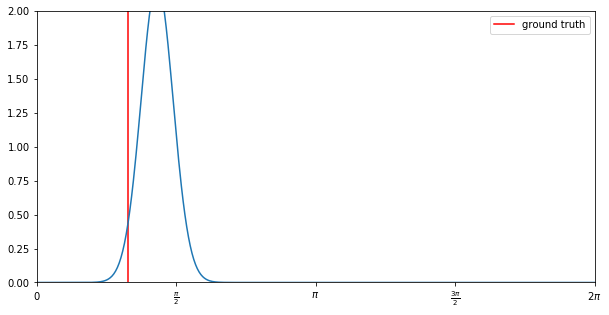

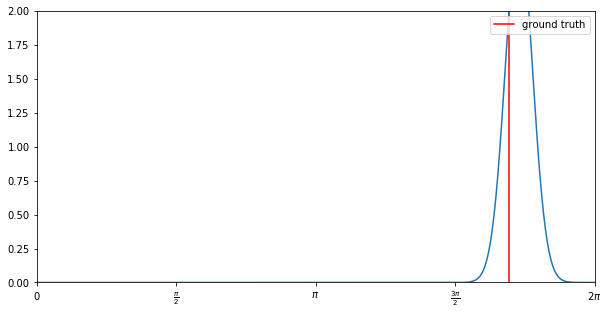

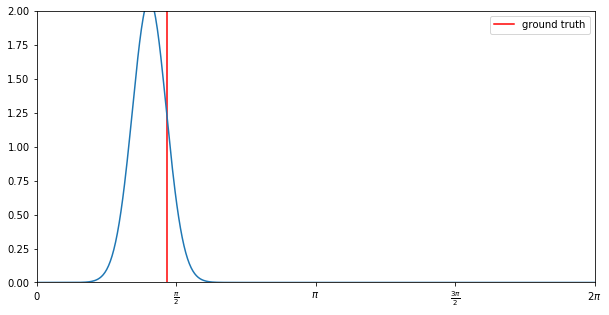

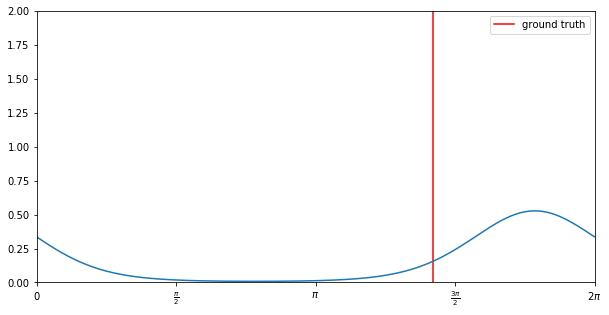

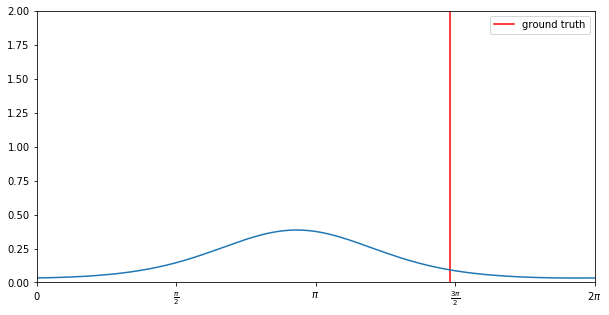

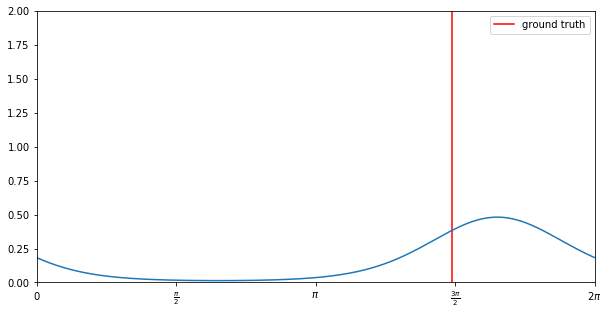

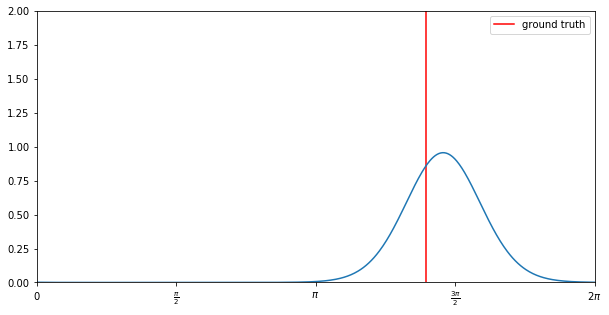

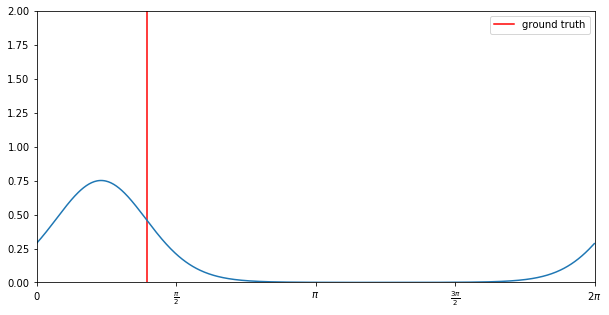

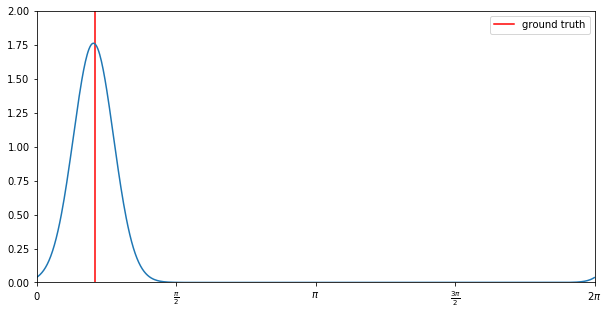

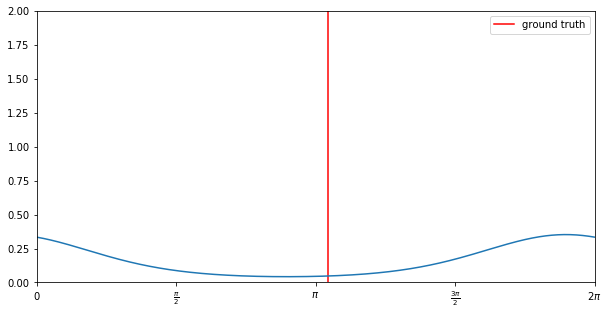

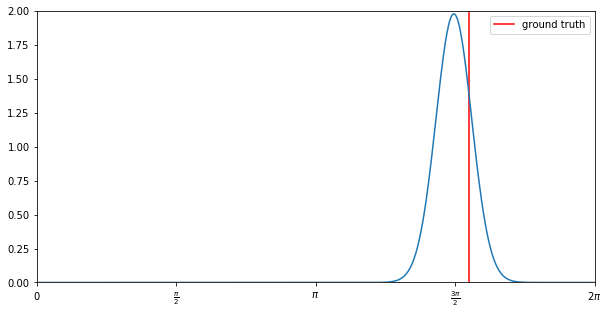

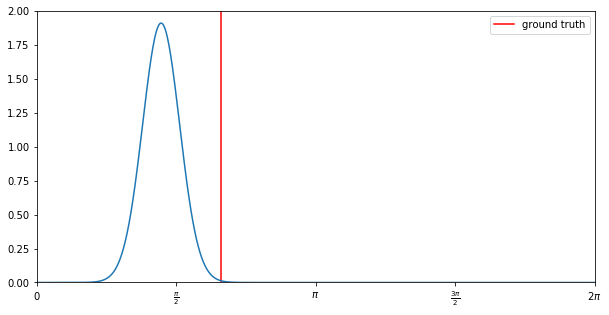

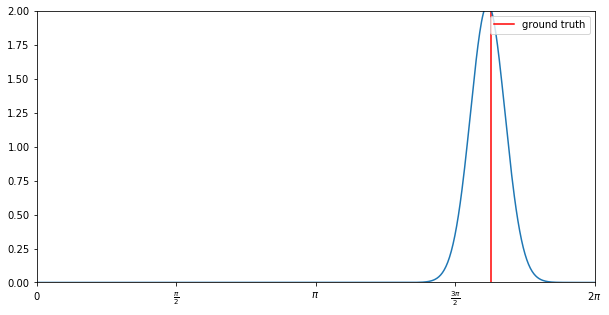

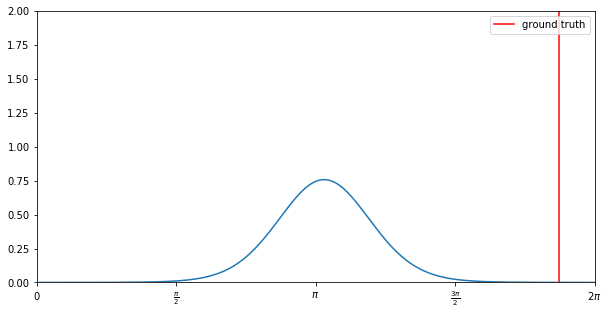

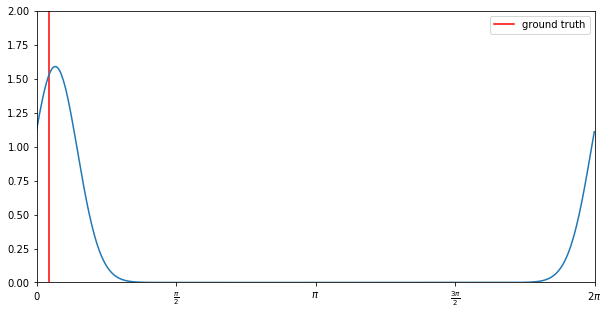

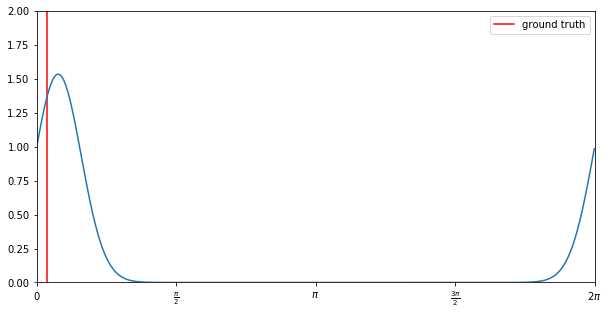

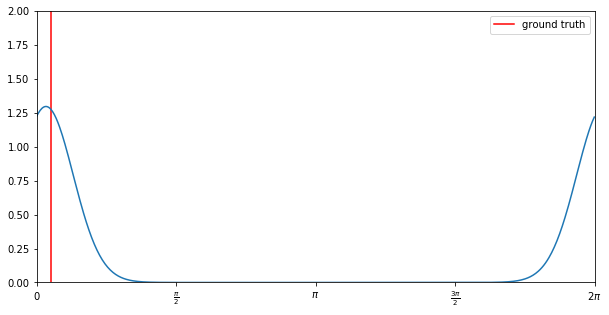

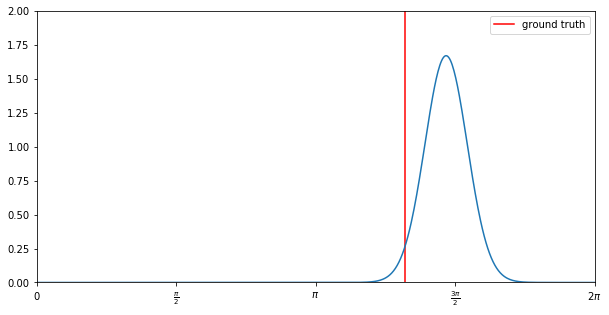

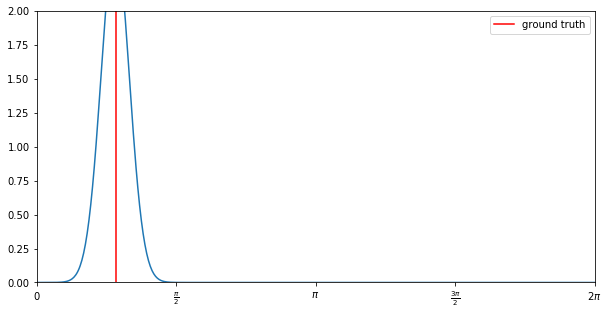

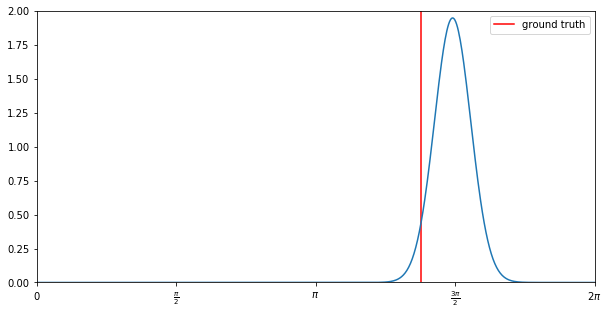

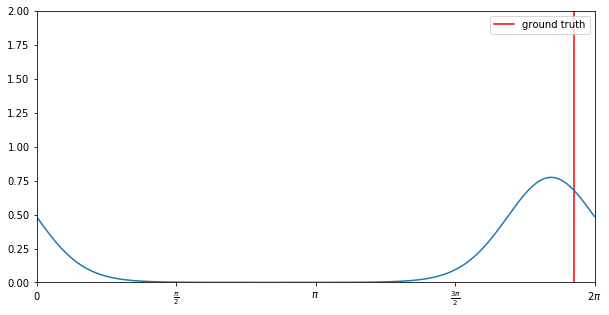

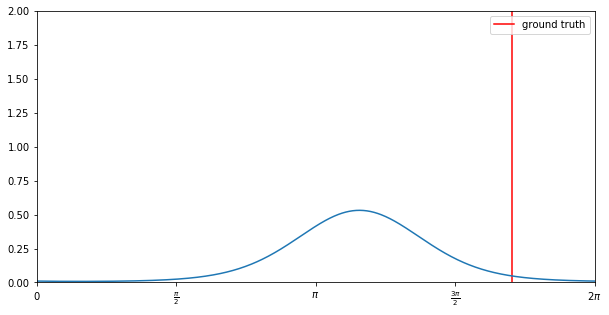

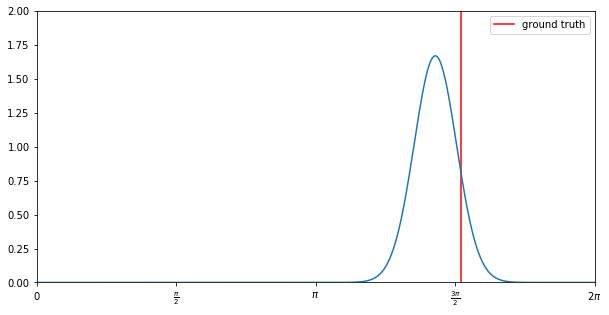

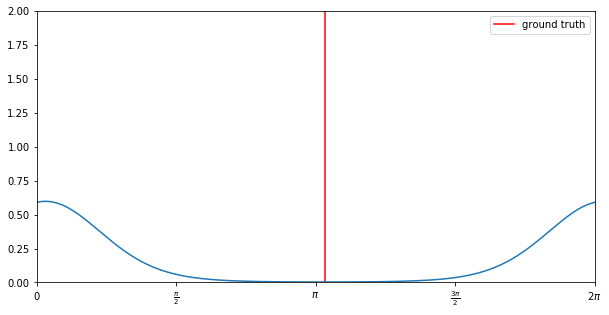

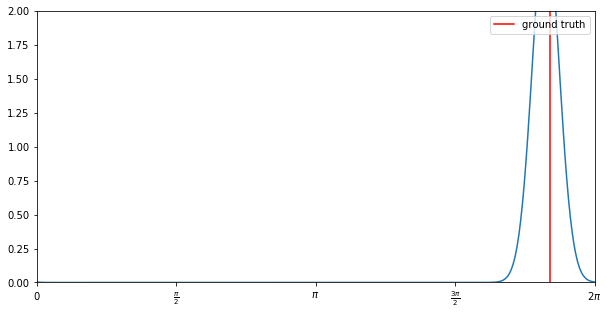

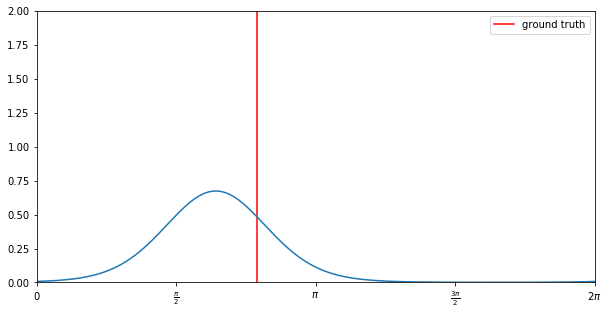

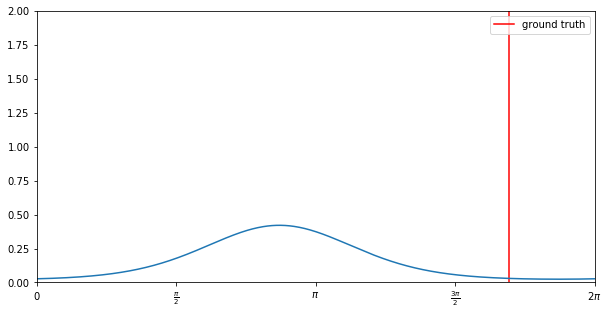

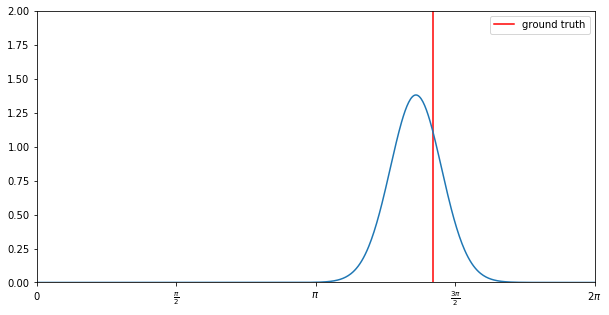

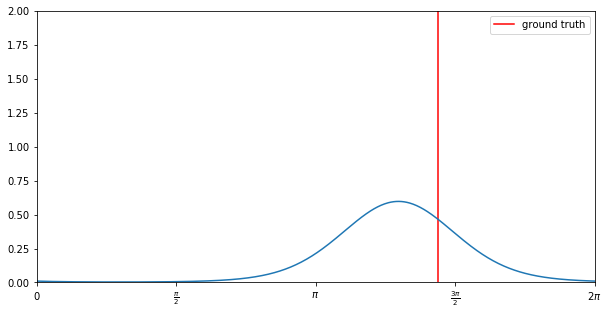

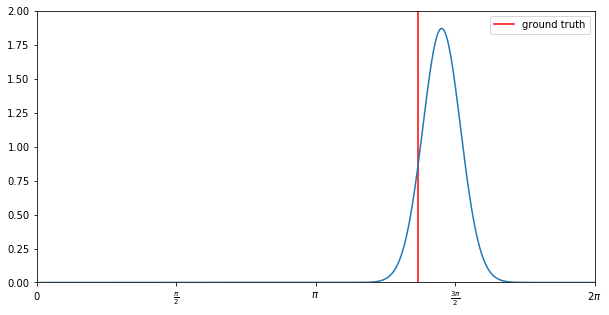

In [16]:
from utils.losses import maximum_expected_utility


data_part = 'test'
images = test_data['images']
y_true = test_data['azimuth_bit']
y_true_deg = test_data['azimuth_deg']
y_true_rad = np.deg2rad(test_data['azimuth_deg'])

print("START!!!")
def _unpack_preds(y_pred):
    
    means = []
    kappas = []
    
    for sid in range(0, n_samples):
        means.append(y_pred[:, sid*3:sid*3+2])
        kappas.append(y_pred[:, sid*3+2:sid*3+3])

    return means, kappas

y_pred_1 = bidisco.predict(images, batch_size=32, verbose=1)
means_1, kappas_1 = _unpack_preds(y_pred_1)
#y_pred_2 = bidisco.predict(images, batch_size=32, verbose=1)
#means_2, kappas_2 = _unpack_preds(y_pred_2)
#diffs = np.abs(bit2deg(means_1[0])-bit2deg(means_1[1])).astype('int')

#print(diffs)

preds_degs = np.asarray([bit2deg(means_1[i]) for i in range(0, n_samples)]).T
print("MAAD (1 sample) : %f" % np.mean(maad_from_deg(bit2deg(y_true), bit2deg(means_1[0]))))
#mae_preds = maximum_expected_utility(preds_degs)
#print("MAAD (MAE) : %f" % np.mean(maad_from_deg(bit2deg(y_true), mae_preds)))


bidisco.load_weights(ckpt_path)
bidisco.evaluate(test_data['images'], test_data['azimuth_bit'])

#likelihoods = np.asarray([np.exp(von_mises_log_likelihood_np(y_true, means_1[i], kappas_1[i])) for i in range(0, n_samples)])
#likelihoods = np.squeeze(likelihoods).T
#avg_loglikelihood = np.mean(np.log(np.mean(likelihoods, axis=1)))
print("log-likelihood: %f" % bidisco.evaluate(images, y_true))


xvals = np.arange(0, 2*np.pi, 0.01)

means = means_1
kappas = kappas_1

vm_acc_pdf, vm_pdfs = acc_pdf(xvals, means, kappas)

for i in range(0, 50):
    #plot_vm_pdf(x_vals, vm_pdfs[i, 0], y_true=np.deg2rad(bit2deg(means_1[0]))[i])
    plot_vm_pdf(xvals, vm_acc_pdf[i], y_true=y_true_rad[i])

#     theta_mean, theta_kappa = _unpack_preds(y_pred) 
    
#     preds_theta = bit2deg(theta_mean)
#     gt_theta = bit2deg(theta_target)
#     aads = maad_from_deg(gt_theta, preds_theta)
#     theta_maad = np.mean(aads)
#     theta_maad_sem = stats.sem(aads)
#     print("MAAD (%s): %f±%f" %(data_part, theta_maad, theta_maad_sem))
#     if fixed_kappa is not None:
#         theta_kappa = np.ones(theta_kappa.shape)*fixed_kappa
#     theta_lls = von_mises_log_likelihood_np(theta_target, theta_mean, theta_kappa)
#     theta_ll = np.mean(theta_lls)
#     theta_ll_sem = stats.sem(theta_lls)
#     print("Log-likelihood (%s): %f±%f" %(data_part, theta_ll, theta_ll_sem))


In [17]:
bidisco.predict(test_data['images'])[:, 0:2]

array([[ 0.998921  ,  0.04644302],
       [-0.31135455, -0.95029384],
       [-0.20475456,  0.9788133 ],
       [ 0.7074072 , -0.70680636],
       [-0.16934274,  0.9855572 ],
       [ 0.11483221,  0.9933849 ],
       [-0.40876567, -0.9126393 ],
       [ 0.07117594, -0.9974638 ],
       [ 0.67469466, -0.73809695],
       [ 0.37801605, -0.9257991 ],
       [ 0.07534399,  0.99715763],
       [-0.08741156,  0.99617225],
       [ 0.3509604 , -0.9363903 ],
       [ 0.6516137 ,  0.7585509 ],
       [ 0.8059216 , -0.5920223 ],
       [-0.34978867, -0.9368287 ],
       [-0.553981  , -0.8325293 ],
       [ 0.23869261,  0.97109514],
       [ 0.45787528,  0.88901645],
       [ 0.29431507,  0.95570844],
       [ 0.21222529,  0.9772208 ],
       [ 0.65816796, -0.7528711 ],
       [ 0.2961754 ,  0.9551336 ],
       [ 0.78188014, -0.6234288 ],
       [-0.9775968 ,  0.21048628],
       [ 0.4580742 , -0.88891387],
       [-0.13374127, -0.99101627],
       [ 0.7476929 ,  0.6640447 ],
       [ 0.80185896,

In [18]:
rfc_predictions = '/lustre/home/sprokudin/RenderForCNN/view_estimation/vp_test_results_backup/aeroplane_pred_view.txt'
render_for_cnn_predictions = np.loadtxt(rfc_predictions, delimiter=' ')
our_model_preds = np.copy(render_for_cnn_predictions)

#azimuth_model = biternion_vgg(image_height, image_width, n_channels, loss_type='likelihood')
#azimuth_model.load_weights('../logs/azimuth_model_likelihood.ckpt')
rfc_azimuth = render_for_cnn_predictions[:, 0]
print("RenderForCNN azimuth preds: %f" %np.mean(maad_from_deg(rfc_azimuth, bit2deg(test_data['azimuth_bit']))))
ours_azimuth_preds  = bit2deg(bidisco.predict(test_data['images'])[:, 0:2]).astype('int')
our_model_preds[:, 0] = ours_azimuth_preds
print("Ours azimuth preds: %f" %np.mean(maad_from_deg(ours_azimuth_preds, bit2deg(test_data['azimuth_bit']))))

# el_model = biternion_vgg(image_height, image_width, n_channels, loss_type='cosine')
# el_model.load_weights('../logs/elevation_model_cosine.ckpt')
# rfc_elevation = render_for_cnn_predictions[:, 1]
# print("RenderForCNN azimuth preds MAAD: %f" %np.mean(maad_from_deg(rfc_elevation, bit2deg(test_data['elevation_bit']))))
# ours_elevation_preds  = bit2deg(el_model.predict(test_data['images'])[:, 0:2]).astype('int')
# our_model_preds[:, 1] = ours_elevation_preds
# print("Ours elevation preds MAAD: %f" %np.mean(maad_from_deg(ours_elevation_preds, bit2deg(test_data['elevation_bit']))))

# tilt_model = biternion_vgg(image_height, image_width, n_channels, loss_type='cosine')
# tilt_model.load_weights('../logs/tilt_model_cosine.ckpt')
# rfc_tilt = render_for_cnn_predictions[:, 2]
# print("RenderForCNN tilt preds MAAD: %f" %np.mean(maad_from_deg(rfc_tilt, bit2deg(test_data['tilt_bit']))))
# ours_tilt_preds  = bit2deg(tilt_model.predict(test_data['images'])[:, 0:2]).astype('int')
# our_model_preds[:, 2] = ours_tilt_preds
# print("Ours tilt preds MAAD: %f" %np.mean(maad_from_deg(ours_tilt_preds, bit2deg(test_data['tilt_bit']))))

save_path = '/lustre/home/sprokudin/RenderForCNN/view_estimation/vp_test_results/aeroplane_pred_view.txt'

np.savetxt(save_path, our_model_preds, delimiter=' ', fmt='%i')

RenderForCNN azimuth preds: 26.269091
Ours azimuth preds: 26.632727


In [15]:
def acc_pdf(xvals, means, kappas):
    
    n_images = len(means[0])
    
    vm_pdfs = np.zeros([n_images, n_samples, len(xvals)])

    x_vals_tiled = np.ones(n_images)

    for xid, xval in enumerate(xvals):

        for sid in range(0, n_samples):

            x_bit = rad2bit(x_vals_tiled*xval)

            vm_pdfs[:, sid, xid] = np.exp(np.squeeze(von_mises_log_likelihood_np(x_bit,
                                                                      means[sid],
                                                                      kappas[sid])))

    vm_acc_pdf = np.mean(vm_pdfs, axis=1)
    return vm_acc_pdf, vm_pdfs

def plot_vm_pdf(x, pdf, ax=None, y_true=None,):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    xticks = [0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
    xticks_labels = ["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)
    
    if y_true is not None:
        ax.axvline(y_true, c='red', label='ground truth')
    # ax.axvline(np.mean(pdf*x), label='mean')
    ax.plot(x, pdf) 
    ax.set_xlim((0, 2*np.pi))
    ax.set_ylim(0, 2.0)
    ax.legend(loc=1)
    
    return 